In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

import os
import pydicom
import numpy as np
import sys
import glob
from matplotlib.widgets import Slider


# import AntsPy
import SimpleITK as sitk

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
import napari



In [ ]:
def mri_to_png(mri_file, png_file):
    """ Function to convert from a DICOM image to png

        @param mri_file: An opened file like object to read te dicom data
        @param png_file: An opened file like object to write the png data
    """

    # Extracting data from the mri file
    plan = pydicom.read_file(mri_file)
    shape = plan.pixel_array.shape

    #Convert to float to avoid overflow or underflow losses.
    image_2d = plan.pixel_array.astype(float)

    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max())

    np.save(png_file, image_2d_scaled.astype(np.float16))


def convert_file(mri_file_path, png_file_path):
    """ Function to convert an MRI binary file to a
        PNG image file.

        @param mri_file_path: Full path to the mri file
        @param png_file_path: Fill path to the png file
    """

    # Making sure that the mri file exists
    if not os.path.exists(mri_file_path):
        raise Exception('File "%s" does not exists' % mri_file_path)

    # Making sure the png file does not exist
    if os.path.exists(png_file_path):
        raise Exception('File "%s" already exists' % png_file_path)

    mri_file = open(mri_file_path, 'rb')
    png_file = open(png_file_path, 'wb')

    mri_to_png(mri_file, png_file)

    png_file.close()


def convert_folder(mri_folder, png_folder):
    """ Convert all MRI files in a folder to png files
        in a destination folder
    """

    # Create the folder for the pnd directory structure
    os.makedirs(png_folder)

    # Recursively traverse all sub-folders in the path
    for mri_sub_folder, subdirs, files in os.walk(mri_folder):
        for mri_file in os.listdir(mri_sub_folder):
            mri_file_path = os.path.join(mri_sub_folder, mri_file)

            # Make sure path is an actual file
            if os.path.isfile(mri_file_path):

                # Replicate the original file structure
                rel_path = os.path.relpath(mri_sub_folder, mri_folder)
                png_folder_path = os.path.join(png_folder, rel_path)
                if not os.path.exists(png_folder_path):
                    os.makedirs(png_folder_path)
                png_file_path = os.path.join(png_folder_path, '%s.npy' % mri_file)

                try:
                    # Convert the actual file
                    convert_file(mri_file_path, png_file_path)
                    print('SUCCESS: %s --> %s' % (mri_file_path, png_file_path))
                except Exception as e:
                    print('FAIL: %s --> %s : %s' % (mri_file_path, png_file_path, e))


Open Data and create 3d visualisation

file count: 1015
skipped, no SliceLocation: 0


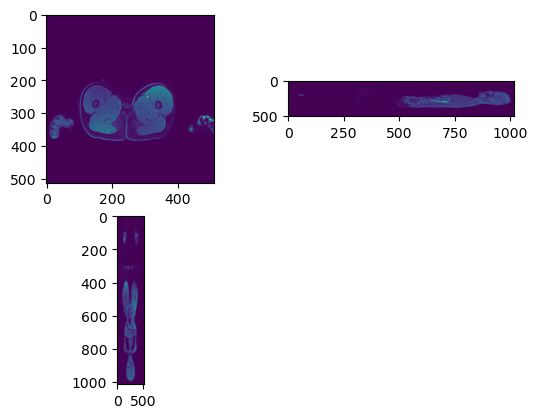

<Figure size 800x800 with 0 Axes>

In [19]:
folderpath = "/Users/pranavrao/Library/CloudStorage/OneDrive-TheUniversityofAuckland/Part4Project/MRI Scans - Tairawhiti/test_AutoBind_M3DLAVA_T1_2450"
# load the DICOM files
files = []
for fname in os.listdir(folderpath):
    #print("loading: {}".format(fname))
    files.append(pydicom.dcmread(folderpath + '/' + fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)
plt.figure(figsize=(8,8))
plt.show()

In [20]:
viewer = napari.view_image(img3d[:, :, :], contrast_limits=[0, 1])

Exposure
- Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest. A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image.

In [21]:
vmin, vmax = np.quantile(img3d, q=(0.005, 0.995))

stretched = exposure.rescale_intensity(
    img3d, 
    in_range=(vmin, vmax), 
    out_range=np.float32
)

viewer.add_image(stretched, contrast_limits=[0, 1], name='stretched')

<Image layer 'stretched' at 0x13752ddc0>

Edge Detection
- highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.
- Sobel operator is an edge detection algorithm that approximates the gradient of the image intensity, and is fast to compute.

In [22]:
edges = filters.sobel(img3d)

viewer = napari.view_image(img3d, blending='additive', colormap='green', name='img')
viewer.add_image(edges, blending='additive', colormap='magenta', name='edges')

<Image layer 'edges' at 0x1347d1700>

Thresholding
-used to create binary images
- A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation.
- Different thresholding algorithms produce different results (An area to tune)

In [24]:
denoised = ndi.median_filter(img3d, size=3)
li_thresholded = denoised > filters.threshold_li(denoised)
viewer.add_image(li_thresholded, name='thresholded', opacity=0.3)

<Image layer 'thresholded' at 0x1413a9430>

AGX: exceeded compiled variants footprint limit
